# Решение спитцеровского уравнения теплопроводности плазмы

## Неявная разностная схема с нелинейностью на нижнем слое иднородностью на верхнем

Для численного решения задачи будем использовать неявную разностную схему с нелинейностью на нижнем слое

$$
\frac{y^{n+1}_{m} - y^{n}_{m}}{\tau} = \frac{1}{h}\left[k^n_{m + 1/2}\frac{y^{n+1}_{m+1} - y^{n+1}_{m}}{h} - k^n_{m - 1/2}\frac{y^{n+1}_{m} - y^{n+1}_{m - 1}}{h}\right] + f^{n + 1}_m
$$

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.pyplot import axes
from celluloid import Camera
import utils

In [21]:
def u_init(x, To):
    u = np.zeros(x.size)
    for i in range(len(x)):
        if x[i] <= 1:
            u[i] = To
    return u

### Реализация метода матричной прогонки

In [22]:
def k_12(y_m, y_m_1, alpha):
    return (y_m ** alpha + y_m_1 ** alpha) / 2

In [48]:
from numpy.linalg import inv


def thomas_block_solver(A, B, C, D):
    M = len(D)
    u_sol = np.zeros_like(D)
    P = np.zeros_like(B)
    Q = np.zeros_like(D)
    # Forward first coefs
    P[0] = inv(B[0]) @ C[0]
    Q[0] = - inv(B[0]) @ D[0]
    # Forward coefs
    for m in range(1, M - 1):
        inv_denom = inv(B[m] - A[m - 1] @ P[m - 1])
        P[m] = inv_denom @ C[m]
        Q[m] = inv_denom @ (A[m - 1] @ Q[m - 1] - D[m])
    #Forward last
    m = M - 1
    Q[m] = inv(B[m] - A[m - 1] @ P[m - 1]) @ (A[m - 1] @ Q[m - 1] - D[m])

    u_sol[-1] = Q[-1]
    for m in range(M - 1, -1, -1):
        u_sol[m - 1] = P[m - 1] @ u_sol[m] + Q[m - 1]

    return u_sol

In [49]:
def make_block_zero(u1, u2, tau, sigma, u1_init, u2_init, alpha=(2.5, 1.5)):
    m = 0
    C = np.diagflat([sigma[0] * k_12(u1[m], u1[m + 1], alpha[0]), sigma[1] * k_12(u2[m], u2[m + 1], alpha[1])])
    b_f1 = tau * (2 * u1_init[m] * u2_init[m] - u2_init[m] ** 2) / u1_init[m] ** 4
    b_f2 = tau / u1_init[m] ** 2
    B = np.eye(2) + C + np.array([[b_f1, -b_f2], [-b_f1, b_f2]])
    d1 = u1_init[m] - u1[m] - C[0, 0] * (u1_init[m + 1] - u1_init[m]) + tau * (u1_init[m] - u2_init[m]) / u1_init[m] ** 2
    d2 = u2_init[m] - u2[m] - C[1, 1] * (u2_init[m + 1] - u2_init[m]) - tau * (u1_init[m] - u2_init[m]) / u1_init[m] ** 2
    D = np.array([d1, d2])
    return B, C, D

In [110]:
def make_block(u1, u2, m, tau, sigma, u1_init, u2_init, alpha=(2.5, 1.5)):
    krit_T = 1e-5
    A = np.diagflat([sigma[0] * k_12(u1[m], u1[m - 1], alpha[0]), sigma[1] * k_12(u2[m], u2[m - 1], alpha[1])])
    C = np.diagflat([sigma[0] * k_12(u1[m], u1[m + 1], alpha[0]), sigma[1] * k_12(u2[m], u2[m + 1], alpha[1])])
    b_f1 = tau * (2 * u1_init[m] * u2_init[m] - u2_init[m] ** 2) / u1_init[m] ** 4 if u1_init[m] >= krit_T else 0
    b_f2 = tau / u1_init[m] ** 2 if u1_init[m] >= krit_T else 0
    B = np.eye(2) + A + C + np.array([[b_f1, -b_f2], [-b_f1, b_f2]])
    d1_f = tau * (u1_init[m] - u2_init[m]) / u1_init[m] ** 2 if u1_init[m] >= krit_T else 0
    d1 = u1_init[m] - u1[m] - C[0, 0] * (u1_init[m + 1] - u1_init[m]) + A[0, 0] * (u1_init[m] - u1_init[m - 1]) + d1_f
    d2_f = tau * (u1_init[m] - u2_init[m]) / u1_init[m] ** 2 if u1_init[m] >= krit_T else 0
    d2 = u2_init[m] - u2[m] - C[1, 1] * (u2_init[m + 1] - u2_init[m]) + A[1, 1] * (u2_init[m] - u2_init[m - 1]) - d2_f
    D = np.array([d1, d2])
    return A, B, C, D

In [111]:
def make_block_diagonals(u1, u2, tau, h, u1_init, u2_init, alpha=(2.5, 1.5), kappa=(0.2, 0.3)):
    M = len(u1)
    A = np.zeros((M - 1, 2, 2))
    B = np.zeros((M, 2, 2))
    C = np.zeros((M - 1, 2, 2))
    D = np.zeros((M, 2))
    sigma = np.array(kappa) * tau / h ** 2
    # first row
    B[0], C[0], D[0] = make_block_zero(u1, u2, tau, sigma, u1_init, u2_init, alpha=(2.5, 1.5))
    # rows m = 1, ..., M - 2
    for m in range(1, M - 1):
        A[m], B[m], C[m], D[m] = make_block(u1, u2, m, tau, sigma, u1_init, u2_init, alpha=alpha)
    # last row
    B[M - 1] = np.eye(2)
    return A, B, C, D

In [112]:
def newton_solver(u1, u2, tau, h, u1_init, u2_init, alpha=(2.5, 1.5), kappa=(0.2, 0.3), iter=10):
    for i in range(iter):
        A, B, C, D = make_block_diagonals(u1, u2, tau, h, u1_init, u2_init, alpha=alpha, kappa=kappa)
        du = thomas_block_solver(A, B, C, D)
        u1_init = u1_init + du[:, 0]
        u2_init = u2_init + du[:, 0]
    return u1_init, u2_init

#### Применение метода

In [113]:
# Начальные значения
a = 0
b = 4
t_0 = 0
T = 0.01
To = 2

In [114]:
# Число узлов
N = 10000
M = 200

# Размер шага сетки
h = (b - a) / (M - 1)
tau = (T - t_0) / (N - 1)
print(f'{h=}, {tau=: .8f}')

print(f'sigma = {tau / h ** 2 * 0.5: .4f}')

h=0.020100502512562814, tau= 0.00000100
sigma =  0.0012


In [115]:
t = np.linspace(t_0, T, N)
x = np.linspace(a, b, M)

In [116]:
u1 = np.zeros((N + 1, M), dtype=np.double)
u1[0, :] = u_init(x, 2)

u2 = np.zeros((N + 1, M), dtype=np.double)
u2[0, :] = u_init(x, 2)

In [117]:
for n in tqdm(range(5)):
    u1_sol, u2_sol = newton_solver(u1[n, :], u2[n, :], tau, h, u1[n, :], u2[n, :], alpha=(2.5, 1.5), kappa=(0.2, 0.3), iter=20)
    u1[n + 1, :], u2[n + 1, :] = u1_sol, u2_sol

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\aleks\AppData\Local\Temp\ipykernel_1608\445448729.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_m ** alpha + y_m_1 ** alpha) / 2


In [118]:
u1[:5, :]

array([[ 2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  0.00000000e+0

In [67]:
u2[:5, :]

array([[ 2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  0.00000000e+0

#### Визуализация

MovieWriter imagemagick unavailable; using Pillow instead.


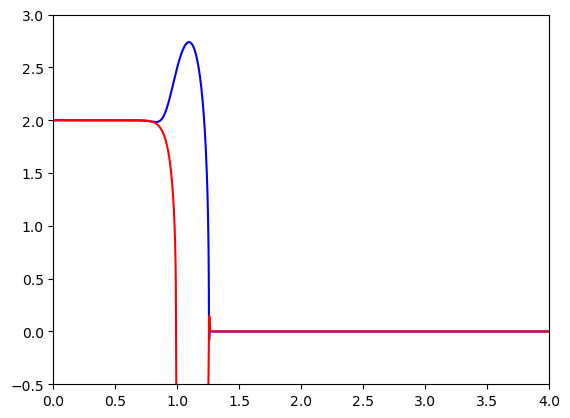

In [81]:
fig = plt.figure()
camera = Camera(fig)
ax = axes(xlim=(a, b), ylim=(-0.5, 3))

for i in range(0, N, 30):
    ax.plot(x, u1[i, :], color="blue")
    ax.plot(x, u2[i, :], color="red")
    camera.snap()
animation = camera.animate()
animation.save('oh_my.gif', writer = 'imagemagick')

In [11]:
from IPython.display import Image
Image(url='oh_my.gif')

### Метод потоковой прогонки

In [11]:
from utils import qei, k_12
from numba import njit


def thomas_Q(u1, u2, n, tau, h, M, mode='electrons'):
    # init
    u_sol = np.zeros(M)
    P = np.zeros(M)
    R = np.zeros(M)
    u = u1[n, :] if mode == 'electrons' else u2[n, :]
    alpha = 2.5 if mode == 'electrons' else 1.5
    kappa = 0.2 if mode == 'electrons' else 0.3
    betta = -1 if mode == 'electrons' else 1
    # Forward first step
    P[0] = tau
    R[0] = tau * betta * qei(u1[n, 0], u2[n, 0]) +  u[0]
    # coefs n = 1 ... M - 2
    for m in range(1, M - 1):
        f = betta * qei(u1[n, m], u2[n, m])
        D = kappa * k_12(u[m - 1], u[m], alpha)
        B = P[m - 1] + h / D
        A = 1 + h * B / tau
        P[m] = B / A
        R[m] = (B * (h * u[m] / tau - h * f) + R[m - 1])

    # backward
    for m in range(M - 1, -1, -1):
        w = kappa * k_12(u[m - 1], u[m], alpha) * (u_sol[m + 1] - u_sol[m]) / h
        u_sol[m] = P[m] * w + R[m]

    return u_sol

#### Применение

In [12]:
# Начальные значения
a = 0
b = 2
t_0 = 0
T = 0.005
To = 2

In [13]:
# Число узлов
N = 6000
M = 400

# Размер шага сетки
h = (b - a) / M
tau = (T - t_0) / N
print(f'{h=}, {tau=: .8f}')

print(f'sigma = {tau / h ** 2 * 0.5: .4f}')

h=0.005, tau= 0.00000083
sigma =  0.0167


In [14]:
t = np.linspace(t_0, T, N)
x = np.linspace(a, b, M)

In [15]:
u1 = np.zeros((N + 1, M), dtype=np.double)
u1[0, :] = u_init(x, 2)

u2 = np.zeros((N + 1, M), dtype=np.double)
u2[0, :] = u_init(x, 2)

In [16]:
for n in tqdm(range(N)):
    u_sol = thomas_Q(u1, u2, n, tau, h, M, mode='electrons')
    u1[n + 1, :] = u_sol
    u_sol = thomas_Q(u1, u2, n, tau, h, M, mode='ions')
    u2[n + 1, :] = u_sol

  0%|          | 0/6000 [00:00<?, ?it/s]

ZeroDivisionError: float division by zero